## A Complex Example: HTMLParser

我们在一个更实际的例子上比较这三种模糊测试器的性能，我们选择Python的HTML解析器作为测试目标。我们将从"空"种子开始，对HTMLParser分别运行这三种模糊测试器各5000次。

解释关键点：

- "more realistic example" - 更实际的例子，指Python的HTML解析器

- "three fuzzers" - 三种模糊测试器，指：
    - 基础的黑盒模糊测试器
    - 普通的灰盒模糊测试器
    - 改进的（boosted）灰盒模糊测试器
- "n = 5k" - 5000次测试运行
- "empty seed" - 从空字符串作为初始种子开始测试
这个例子比之前的crashme函数更复杂，更能体现不同模糊测试策略的优劣。

In [1]:
from html.parser import HTMLParser

In [2]:
# create wrapper function
def my_parser(inp: str) -> None:
    parser = HTMLParser()  # resets the HTMLParser object for every fuzz input
    parser.feed(inp)

In [22]:
from fuzzingbook.GreyboxFuzzer import AdvancedMutationFuzzer, GreyboxFuzzer, CountingGreyboxFuzzer
from fuzzingbook.GreyboxFuzzer import Seed, Mutator, PowerSchedule
from fuzzingbook.GreyboxFuzzer import AFLFastSchedule
import time
from fuzzingbook.MutationFuzzer import FunctionCoverageRunner
from fuzzingbook.Coverage import population_coverage
from matplotlib import pyplot as plt

In [24]:
n = 50000
seed_input = " "  # empty seed
blackbox_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())
boosted_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), AFLFastSchedule(5))

In [ ]:
start = time.time()
blackbox_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
greybox_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
boosted_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
end = time.time()

"It took all three fuzzers %0.2f seconds to generate and execute %d inputs." % (end - start, n)

这些模糊测试器在随时间推移的代码覆盖率方面如何比较？

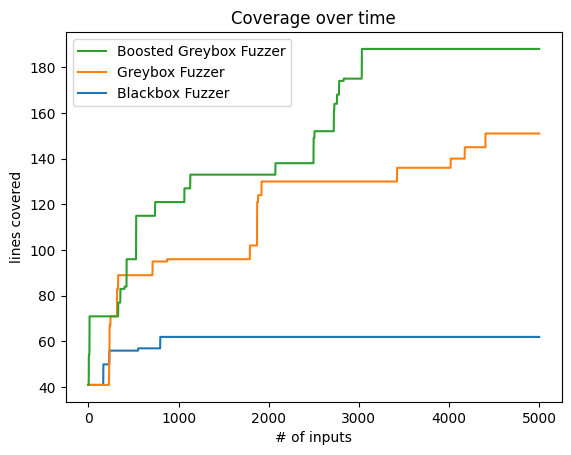

In [23]:
_, black_coverage = population_coverage(blackbox_fuzzer.inputs, my_parser)
_, grey_coverage = population_coverage(greybox_fuzzer.inputs, my_parser)
_, boost_coverage = population_coverage(boosted_fuzzer.inputs, my_parser)
line_black, = plt.plot(black_coverage, label="Blackbox Fuzzer")
line_grey, = plt.plot(grey_coverage, label="Greybox Fuzzer")
line_boost, = plt.plot(boost_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_boost, line_grey, line_black])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');